In [1]:
# Import the functions used in this project
import awesome_functions as af
import decode_utils as du
from sklearn.externals import joblib

# Pretty display for notebooks
%matplotlib inline

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("../asset/train.csv")
test = pd.read_csv("../asset/test.csv")
submission = pd.read_csv("../asset/sample_submission.csv")

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("submission  data : ", submission.shape)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle as pkl
slack_url = pkl.load(open("Slack_url/send_url.pickle", "rb"))

import xgboost
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import csr_matrix
def fitNaiveBayesModel(X, y):
    return MultinomialNB(alpha=0.0).fit(X, y)

# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_test = test.copy()
df_submission = submission.copy()

df_train_dd = pd.read_csv("Feature_matrix/df_train_dd_201807291831.csv")
df_test_dd = pd.read_csv("Feature_matrix/df_test_dd_201807291855.csv")
df_train_fl = pd.read_csv("Feature_matrix/df_train_fl_201807291845.csv")
df_test_fl = pd.read_csv("Feature_matrix/df_test_fl_201807291908.csv")
# df_ratio = pd.read_csv("Feature_matrix/df_new_has_all_the_ratio_201808031807.csv")

Train data :  (647054, 7)
Test  data :  (653646, 6)
submission  data :  (95674, 39)


In [18]:
df_train_cp = pd.read_csv("Feature_matrix/df_train_cp_201808062200.csv")

In [2]:
# import decode_utils as du
# import awesome_functions as af
from sklearn.metrics import confusion_matrix
from IPython.display import display, Markdown

def getAccuracy(y_true, y_pred, data_length, i):
    """
        y_true : 원래 타겟 컬럼의 데이터를 넣어준다.
        y_pred : 예측한 값을 넣어준다.
        data_length : 예측한 데이터의 총 개수를 넣어준다.
    """
    accuracy = round(np.trace(confusion_matrix(y_true, y_pred))/data_length, 4)
    display(Markdown("##### Accuracy : " + str(accuracy) + ", smoothing : " + str(i)))
    return accuracy

def fitNaiveBayesModel_smoothing(X, y, a = 1.0):
    return MultinomialNB(alpha=a).fit(X, y)

def __combine_dd_fl(df_dd, df_fl):
    col_we_dont_need = ["VisitNumber", "TripType", 'Return', 'Monday',\
                        'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    cols_we_need = [col for col in df_dd.columns if col not in col_we_dont_need]
    cols = [col for col in cols_we_need if col != "VisitNumber"]
    return du.concatDf(df_dd[cols], df_fl)
    
def get_concat_df_for_test_df(df_dd, df_fl):
    return __combine_dd_fl(df_dd, df_fl)
    
def get_df_has_specified_vn_list(vn_list, df=None, df_dd=None, df_fl=None, is_in=True,
                                 is_need_to_make_df = False):
    if is_need_to_make_df:
        df = __combine_dd_fl(df_dd, df_fl)
        print("Concat 완료.")
    if is_in:
        return df[df.VisitNumber.isin(vn_list)]
    return df[~df.VisitNumber.isin(vn_list)]

def test_multinomial(df, early_stop = 5):
    X, y = af.get_df_to_fit(df)
    a = np.arange(0, 0.16, 0.01)
    accuracy_ = 0
    count = 0
    result = []
    alpha = []
    for i in a:
        if count >= early_stop:
            best_score = np.array(result).max()
            idx = result.index(best_score)
            display(Markdown("## Best_score : " + str(best_score) + ", Alpha : " + str(alpha[idx])))
            return
        model_nb = fitNaiveBayesModel_smoothing(X, y, i)
        y_pred = model_nb.predict(X)
        accuracy = getAccuracy(y, y_pred, len(X), i)
        if accuracy_ > accuracy:
            count += 1
        accuracy_ = accuracy
        result.append(accuracy)
        alpha.append(i)
    best_score = np.array(result).max()
    idx = result.index(best_score)
    display(Markdown("## Best_score : " + str(best_score) + ", Alpha : " + str(alpha[idx])))
#     return best_score, alpha[idx]

def cal_average_of_accuracy(li1, li2, score_li):    
    li3 = 96574 - len(li1 + li2)
    weight = [len(li1), len(li2), li3]
    result = 0
    for i, score in enumerate(score_li):
        result += weight[i] * score
    result = result/96574
    print(result)
    return result

In [158]:
df_decoded = du.decodeStuffNeedsToBeDecoded(df_train)

In [4]:
hs_li = pd.read_csv("Feature_matrix/only_point_one_dd.csv")

In [10]:
important_fl_li = hs_li["fl"].dropna().values

In [11]:
important_company_li = hs_li["comp"].dropna().values

In [12]:
len(important_fl_li), len(important_company_li)

(241, 577)

In [15]:
important_fl_li = important_fl_li.astype(str)

In [19]:
important_company_li = important_company_li.astype(str)

In [17]:
new_train_fl = df_train_fl[important_fl_li]

In [31]:
new_df = pd.concat([df_train_dd, new_train_fl], axis = 1)

In [33]:
X, y = af.get_df_to_fit(new_df)

In [34]:
test_multinomial(new_df)

##### Accuracy : 0.5818, smoothing : 0.0

##### Accuracy : 0.5812, smoothing : 0.01

##### Accuracy : 0.5813, smoothing : 0.02

##### Accuracy : 0.5813, smoothing : 0.03

##### Accuracy : 0.5812, smoothing : 0.04

##### Accuracy : 0.5812, smoothing : 0.05

##### Accuracy : 0.5813, smoothing : 0.06

##### Accuracy : 0.5813, smoothing : 0.07

##### Accuracy : 0.5814, smoothing : 0.08

##### Accuracy : 0.5814, smoothing : 0.09

##### Accuracy : 0.5815, smoothing : 0.1

##### Accuracy : 0.5816, smoothing : 0.11

##### Accuracy : 0.5816, smoothing : 0.12

##### Accuracy : 0.5816, smoothing : 0.13

##### Accuracy : 0.5817, smoothing : 0.14

##### Accuracy : 0.5817, smoothing : 0.15

## Best_score : 0.5818, Alpha : 0.0

In [63]:
try_new_stuff = df_train.groupby(["FinelineNumber", "DepartmentDescription"]).sum()["ScanCount"].reset_index()

In [69]:
f_fl_ = df_train.groupby(["FinelineNumber", "TripType"]).size().reset_index(name="Size")

In [194]:
f_cp_ = df_decoded.groupby(["Company", "TripType"]).size().reset_index(name="Size")

In [200]:
f_cp = pd.pivot_table(data=f_cp_, index="TripType", columns="Company", values="Size", fill_value=0, aggfunc=np.sum)

In [202]:
model_ = fitNaiveBayesModel(f_cp, f_cp.index)

In [207]:
df_train_cp.columns[10:]

Index(['-9999', '00', '000000', '000050', '000300', '000337', '000450',
       '000561', '000651', '000716',
       ...
       '898999', '899053', '899157', '899274', '899407', '899539', '899675',
       '899792', '95', '98'],
      dtype='object', length=5687)

In [209]:
y_pred = model_.predict(df_train_cp[df_train_cp.columns[10:]])

In [210]:
af.getAccuracy(df_train_dd["TripType"], y_pred, len(df_train_cp))

##### Accuracy : 0.4884

In [147]:
f_dd_ = df_train.groupby(["DepartmentDescription", "TripType"]).size().reset_index(name="Size")

In [148]:
f_dd = pd.pivot_table(data=f_dd_, index="DepartmentDescription", columns="TripType", values="Size", fill_value=0)

In [80]:
from sklearn.preprocessing import normalize

In [82]:
S = normalize(f_dd)

In [83]:
S = np.dot(S, S.T)

In [88]:
S_dd = pd.DataFrame(S, columns=f_dd.index, index = f_dd.index)

In [174]:
S_dd.loc["FINANCIAL SERVICES"]

DepartmentDescription
1-HR PHOTO                    0.163035
ACCESSORIES                   0.148373
AUTOMOTIVE                    0.135534
BAKERY                        0.144860
BATH AND SHOWER               0.127011
BEAUTY                        0.146005
BEDDING                       0.137602
BOOKS AND MAGAZINES           0.159735
BOYS WEAR                     0.109394
BRAS & SHAPEWEAR              0.141583
CAMERAS AND SUPPLIES          0.194878
CANDY, TOBACCO, COOKIES       0.143086
CELEBRATION                   0.109354
COMM BREAD                    0.124929
CONCEPT STORES                0.444264
COOK AND DINE                 0.154241
DAIRY                         0.126580
DSD GROCERY                   0.131978
ELECTRONICS                   0.253367
FABRICS AND CRAFTS            0.115324
FINANCIAL SERVICES            1.000000
FROZEN FOODS                  0.124853
FURNITURE                     0.108338
GIRLS WEAR, 4-6X  AND 7-14    0.109746
GROCERY DRY GOODS             0.122457
HAR

In [135]:
df_train_dd

,VisitNumber,TripType,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,5,999,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,7,30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,8,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,9,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,10,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,11,35,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,12,41,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,15,21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,17,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,19,42,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


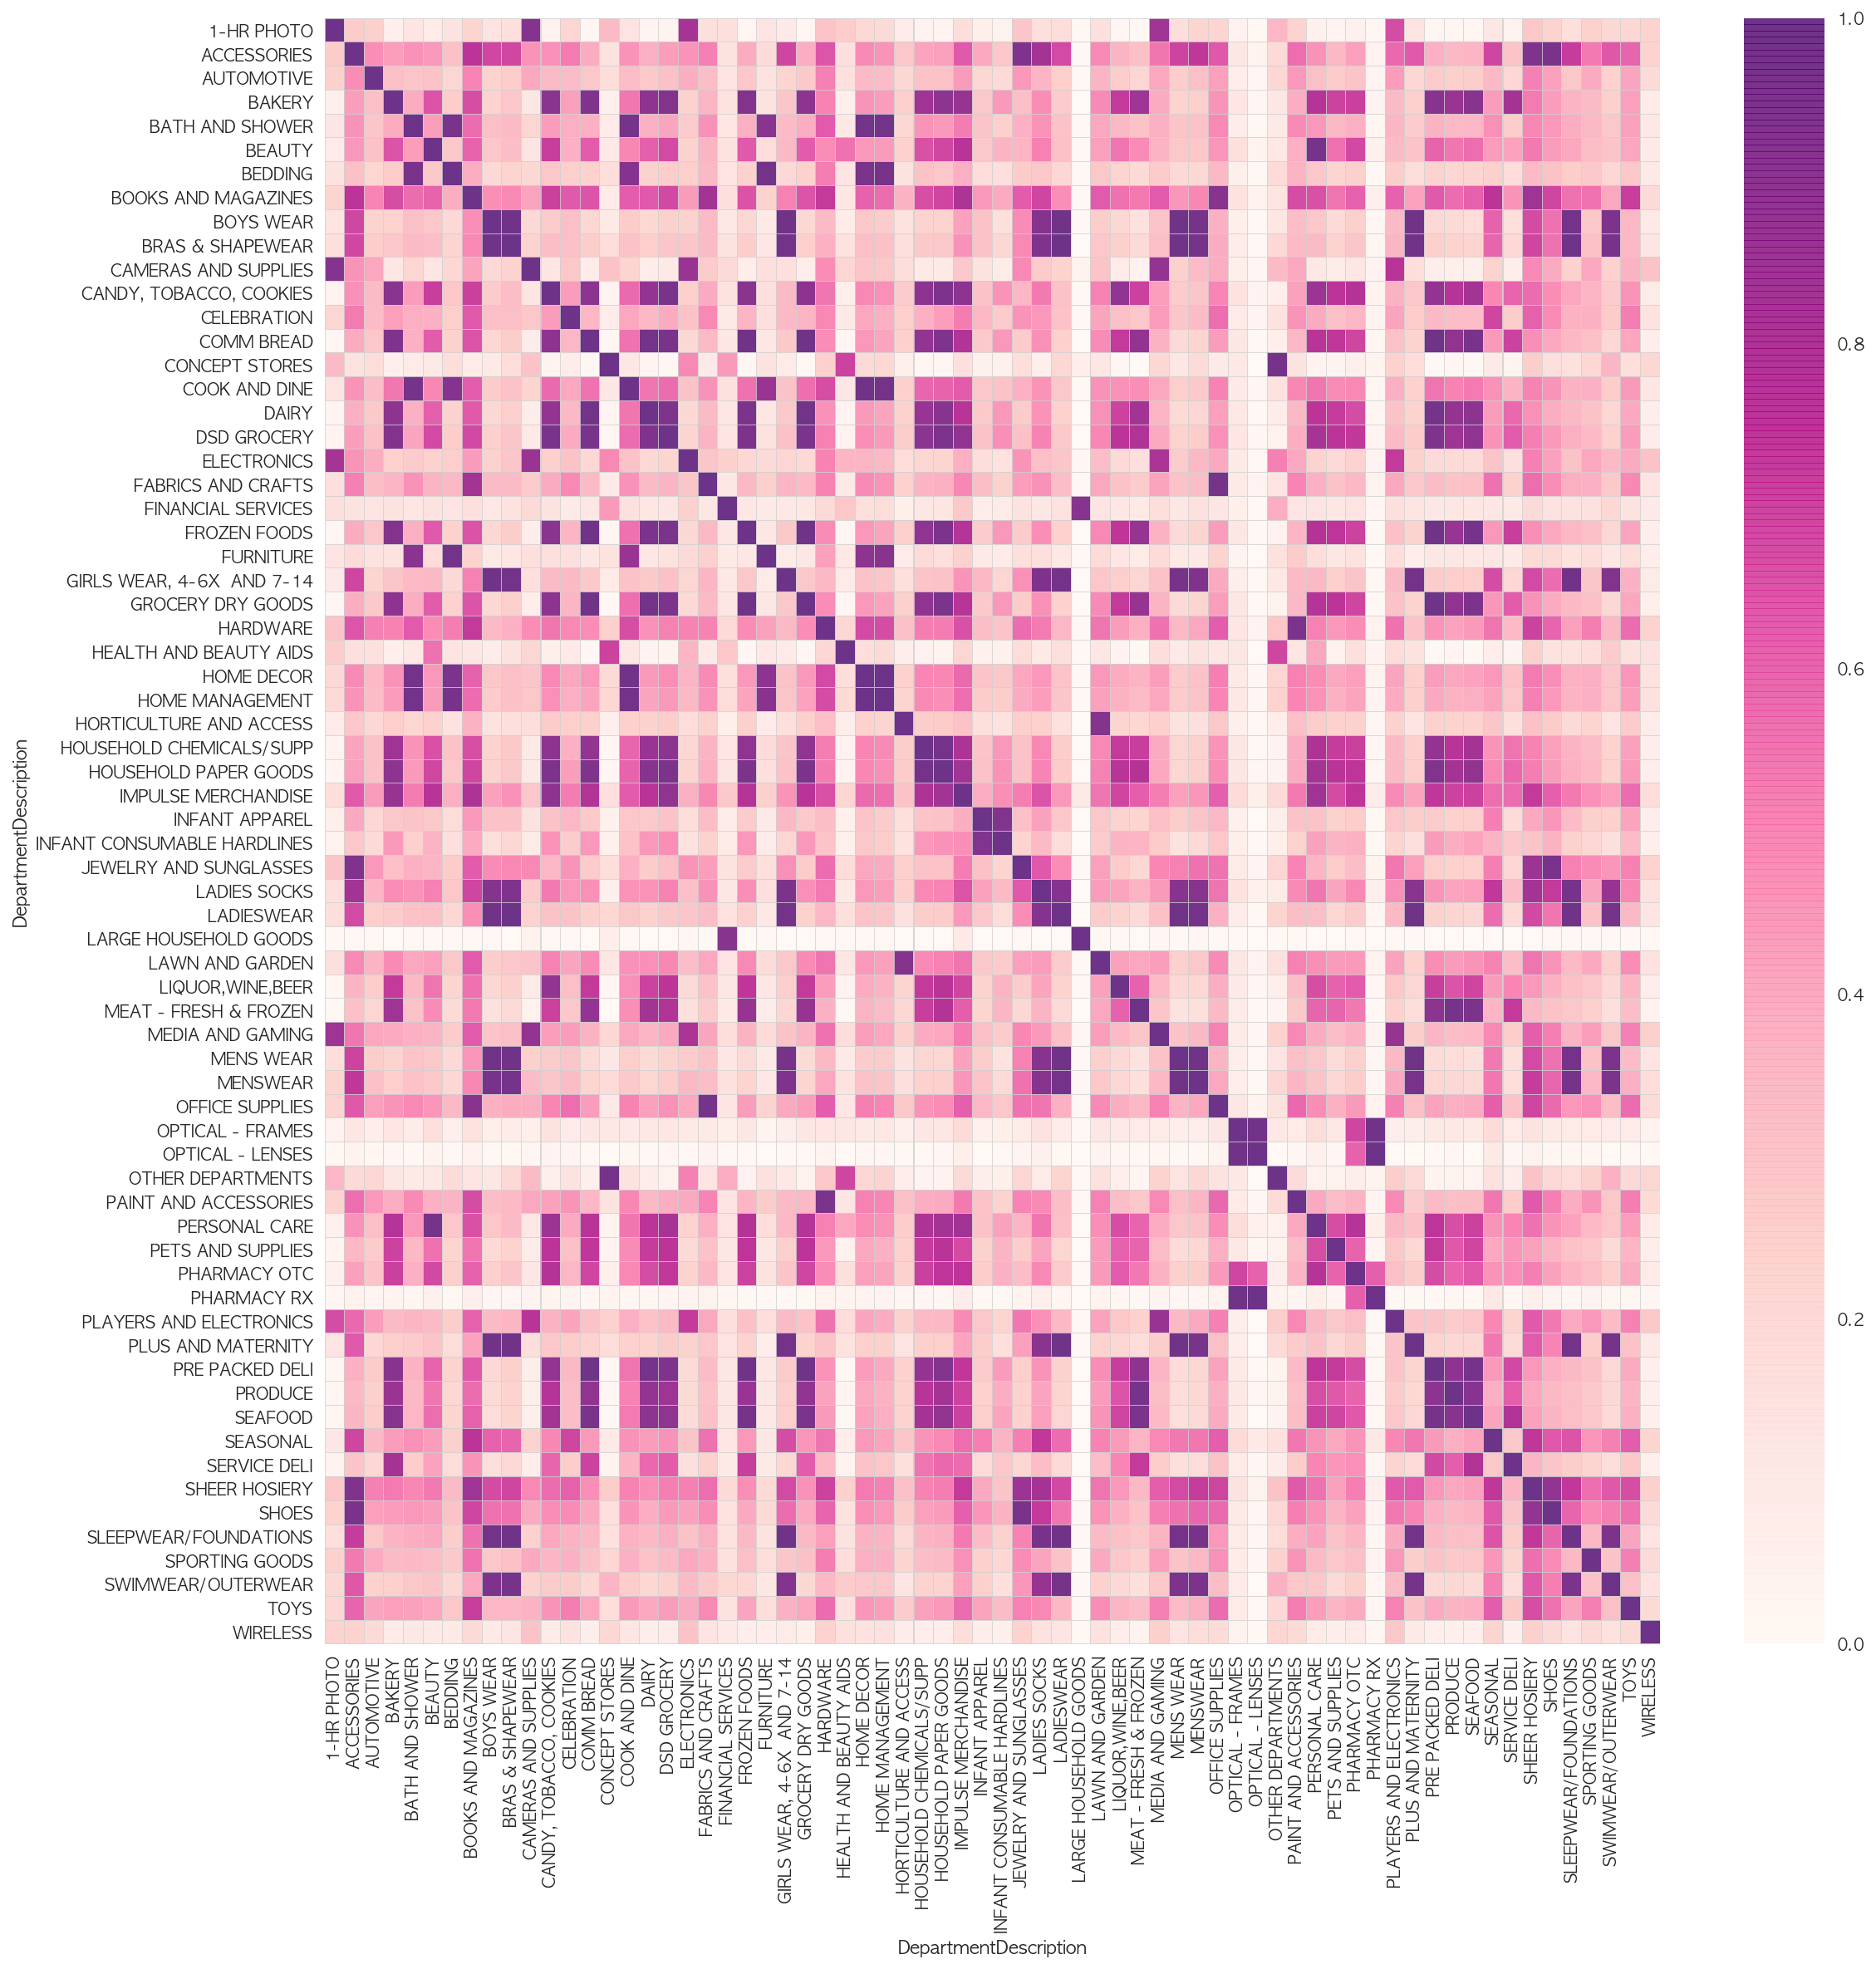

In [91]:
plt.figure(figsize=(18, 18))
sns.heatmap(S_dd, linecolor="lightgrey", linewidths=0.02, cmap="RdPu", alpha=.8)
plt.show()

In [113]:
cols = f_dd.columns[:-1]

In [115]:
f_dd.columns = cols.insert(len(cols), 45)

In [122]:
f_dd.index[1]

'ACCESSORIES'

In [152]:
def getSpecifiedVisitNumberData(df_train, vn):
    display(df_train[df_train.VisitNumber == vn])
#     display(df_train_dd[df_train_dd.VisitNumber == vn])

In [156]:
getSpecifiedVisitNumberData(df_train, 17)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
51,6,17,Friday,2.840009e+09,1,DSD GROCERY,3352.0
52,6,17,Friday,2.610001e+09,1,"CANDY, TOBACCO, COOKIES",8012.0
53,6,17,Friday,1.200004e+09,1,DSD GROCERY,9501.0
54,6,17,Friday,3.170005e+09,1,"CANDY, TOBACCO, COOKIES",8430.0


In [164]:
df_decoded.DepartmentDescription.unique()

array(['FINANCIAL SERVICES', 'SHOES', 'PERSONAL CARE',
       'PAINT AND ACCESSORIES', 'DSD GROCERY', 'MEAT - FRESH & FROZEN',
       'DAIRY', 'PETS AND SUPPLIES', 'HOUSEHOLD CHEMICALS/SUPP', 'NULL',
       'IMPULSE MERCHANDISE', 'PRODUCE', 'CANDY, TOBACCO, COOKIES',
       'GROCERY DRY GOODS', 'BOYS WEAR', 'FABRICS AND CRAFTS',
       'JEWELRY AND SUNGLASSES', 'MENS WEAR', 'ACCESSORIES',
       'HOME MANAGEMENT', 'FROZEN FOODS', 'SERVICE DELI',
       'INFANT CONSUMABLE HARDLINES', 'PRE PACKED DELI', 'COOK AND DINE',
       'PHARMACY OTC', 'LADIESWEAR', 'COMM BREAD', 'BAKERY',
       'HOUSEHOLD PAPER GOODS', 'CELEBRATION', 'HARDWARE', 'BEAUTY',
       'AUTOMOTIVE', 'BOOKS AND MAGAZINES', 'SEAFOOD', 'OFFICE SUPPLIES',
       'LAWN AND GARDEN', 'SHEER HOSIERY', 'WIRELESS', 'BEDDING',
       'BATH AND SHOWER', 'HORTICULTURE AND ACCESS', 'HOME DECOR', 'TOYS',
       'INFANT APPAREL', 'LADIES SOCKS', 'PLUS AND MATERNITY',
       'ELECTRONICS', 'GIRLS WEAR, 4-6X  AND 7-14', 'BRAS & SHAPEWEA

In [187]:
df_decoded[df_decoded.DepartmentDescription == "FINANCIAL SERVICES"].Company.unique()

array(['681131', '605388', '729515', '400086', '799366'], dtype=object)

In [193]:
df_decoded[df_decoded.Company == "799366"]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Company
402,31,209,Friday,799366619666,1,WIRELESS,765,799366
650,31,288,Friday,799366317036,1,WIRELESS,1065,799366
1534,31,666,Friday,799366678564,2,IMPULSE MERCHANDISE,1748,799366
1880,3,818,Friday,799366631958,1,IMPULSE MERCHANDISE,1749,799366
2430,9,1043,Friday,799366189145,2,WIRELESS,965,799366
2676,15,1116,Friday,799366793991,2,IMPULSE MERCHANDISE,8022,799366
2758,31,1137,Friday,799366820666,1,WIRELESS,1065,799366
4313,15,1664,Friday,799366530282,1,IMPULSE MERCHANDISE,8022,799366
4314,15,1664,Friday,799366580744,1,IMPULSE MERCHANDISE,8022,799366
4559,3,1735,Friday,799366753018,1,LARGE HOUSEHOLD GOODS,2,799366


In [185]:
getSpecifiedVisitNumberData(df_train, 351)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
760,999,351,Friday,6.811318e+10,1,FINANCIAL SERVICES,281.0
761,999,351,Friday,6.811318e+10,1,FINANCIAL SERVICES,280.0


In [179]:
df_decoded[df_decoded.DepartmentDescription=="CONCEPT STORES"]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Company
27003,999,8358,Saturday,015645688407,1,CONCEPT STORES,4392,015645
28789,999,8898,Saturday,067000008504,1,CONCEPT STORES,4392,067000
30779,999,9404,Saturday,015645688407,1,CONCEPT STORES,4392,015645
75363,999,21471,Monday,015645688407,1,CONCEPT STORES,4392,015645
83943,999,23990,Monday,015645688407,1,CONCEPT STORES,4392,015645
116463,999,34444,Wednesday,067000008504,2,CONCEPT STORES,4392,067000
116963,999,34647,Wednesday,067000008504,1,CONCEPT STORES,4392,067000
121866,999,36172,Wednesday,015645688407,1,CONCEPT STORES,4392,015645
127105,999,37935,Thursday,015645688407,1,CONCEPT STORES,4392,015645
136016,999,41003,Thursday,015645688407,2,CONCEPT STORES,4392,015645


In [184]:
df_train[(df_train.DepartmentDescription == "FINANCIAL SERVICES") & (df_train.TripType == 999)]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
509,999,253,Friday,6.811318e+10,-1,FINANCIAL SERVICES,279.0
590,999,281,Friday,6.811318e+10,-1,FINANCIAL SERVICES,279.0
709,999,317,Friday,6.053881e+10,-1,FINANCIAL SERVICES,279.0
760,999,351,Friday,6.811318e+10,1,FINANCIAL SERVICES,281.0
761,999,351,Friday,6.811318e+10,1,FINANCIAL SERVICES,280.0
762,999,357,Friday,6.053881e+10,1,FINANCIAL SERVICES,287.0
763,999,357,Friday,6.811311e+10,1,FINANCIAL SERVICES,286.0
949,999,403,Friday,6.053881e+10,-1,FINANCIAL SERVICES,279.0
950,999,407,Friday,6.811318e+10,-1,FINANCIAL SERVICES,279.0


In [155]:
display(f_dd[[35, 36]])

TripType,35,36
DepartmentDescription,,
1-HR PHOTO,3,7
ACCESSORIES,3,31
AUTOMOTIVE,27,88
BAKERY,186,83
BATH AND SHOWER,13,120
BEAUTY,41,3843
BEDDING,4,24
BOOKS AND MAGAZINES,9,21
BOYS WEAR,17,36


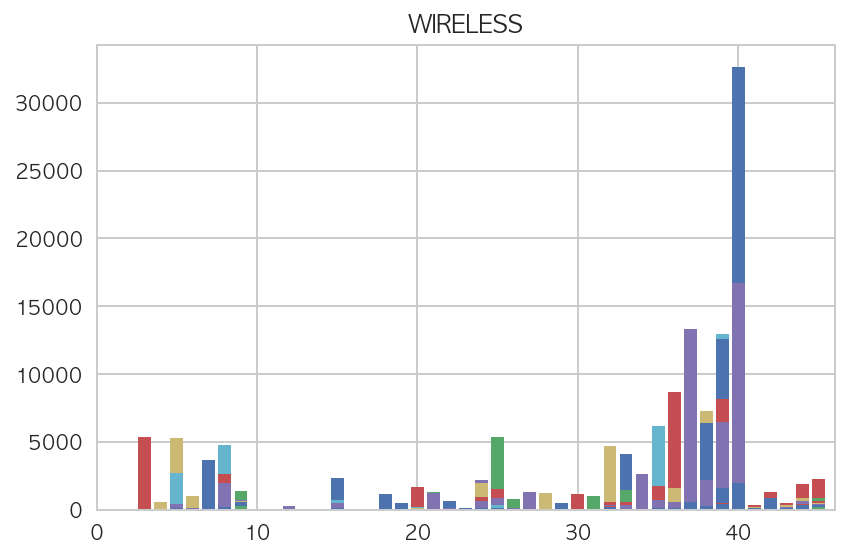

In [130]:
plt.title(f_dd.index[i])
plt.bar(f_dd.iloc[i].index, f_dd.iloc[i].values)
plt.xlim(0, 46)
plt.tight_layout()
plt.show()

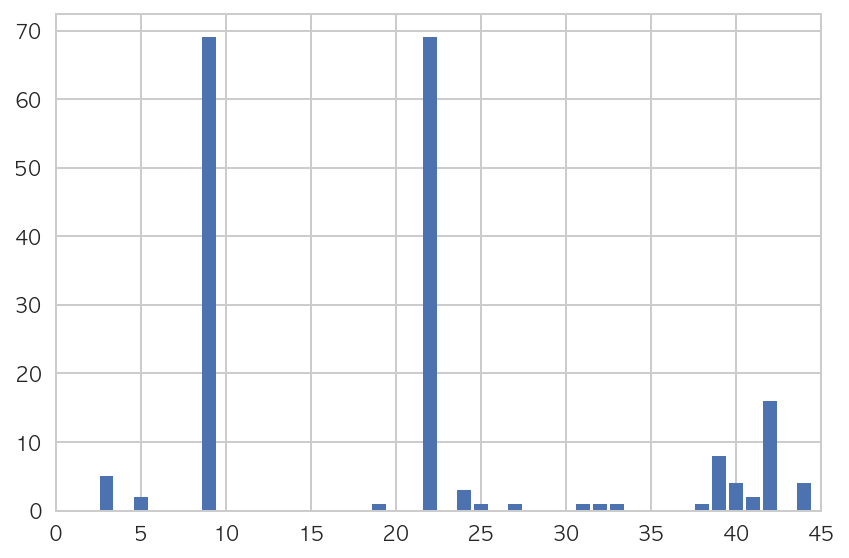

In [100]:
plt.bar(f_dd.loc["CAMERAS AND SUPPLIES"].index, f_dd.loc["CAMERAS AND SUPPLIES"].values)
plt.xlim(0, 45)
# plt.bar(f_dd.loc["CAMERAS AND SUPPLIES"].index, f_dd.loc["CAMERAS AND SUPPLIES"].values, ax=ax2)
plt.tight_layout()
plt.show()

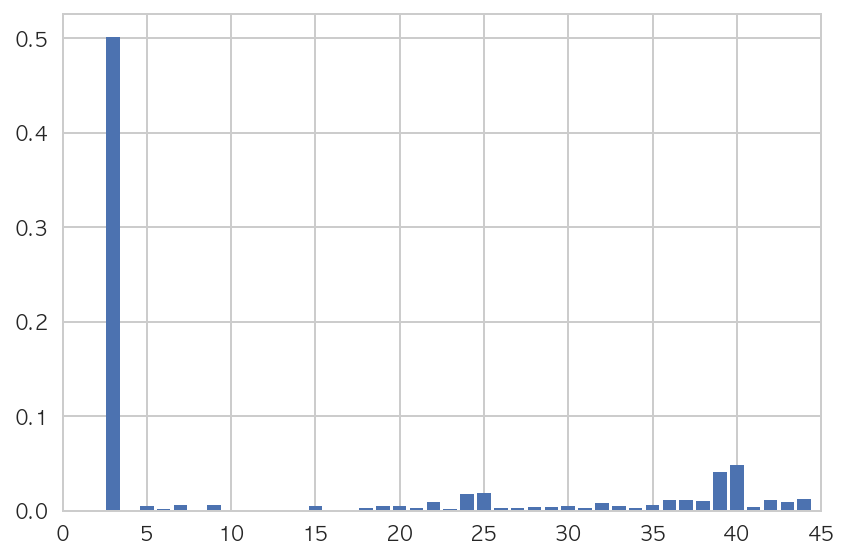

In [178]:

plt.bar(f_dd.loc["FINANCIAL SERVICES"].index, f_dd.loc["FINANCIAL SERVICES"].values / f_dd.loc["FINANCIAL SERVICES"].values.sum())
plt.xlim(0, 45)
# plt.bar(f_dd.loc["CAMERAS AND SUPPLIES"].index, f_dd.loc["CAMERAS AND SUPPLIES"].values, ax=ax2)
plt.tight_layout()
plt.show()

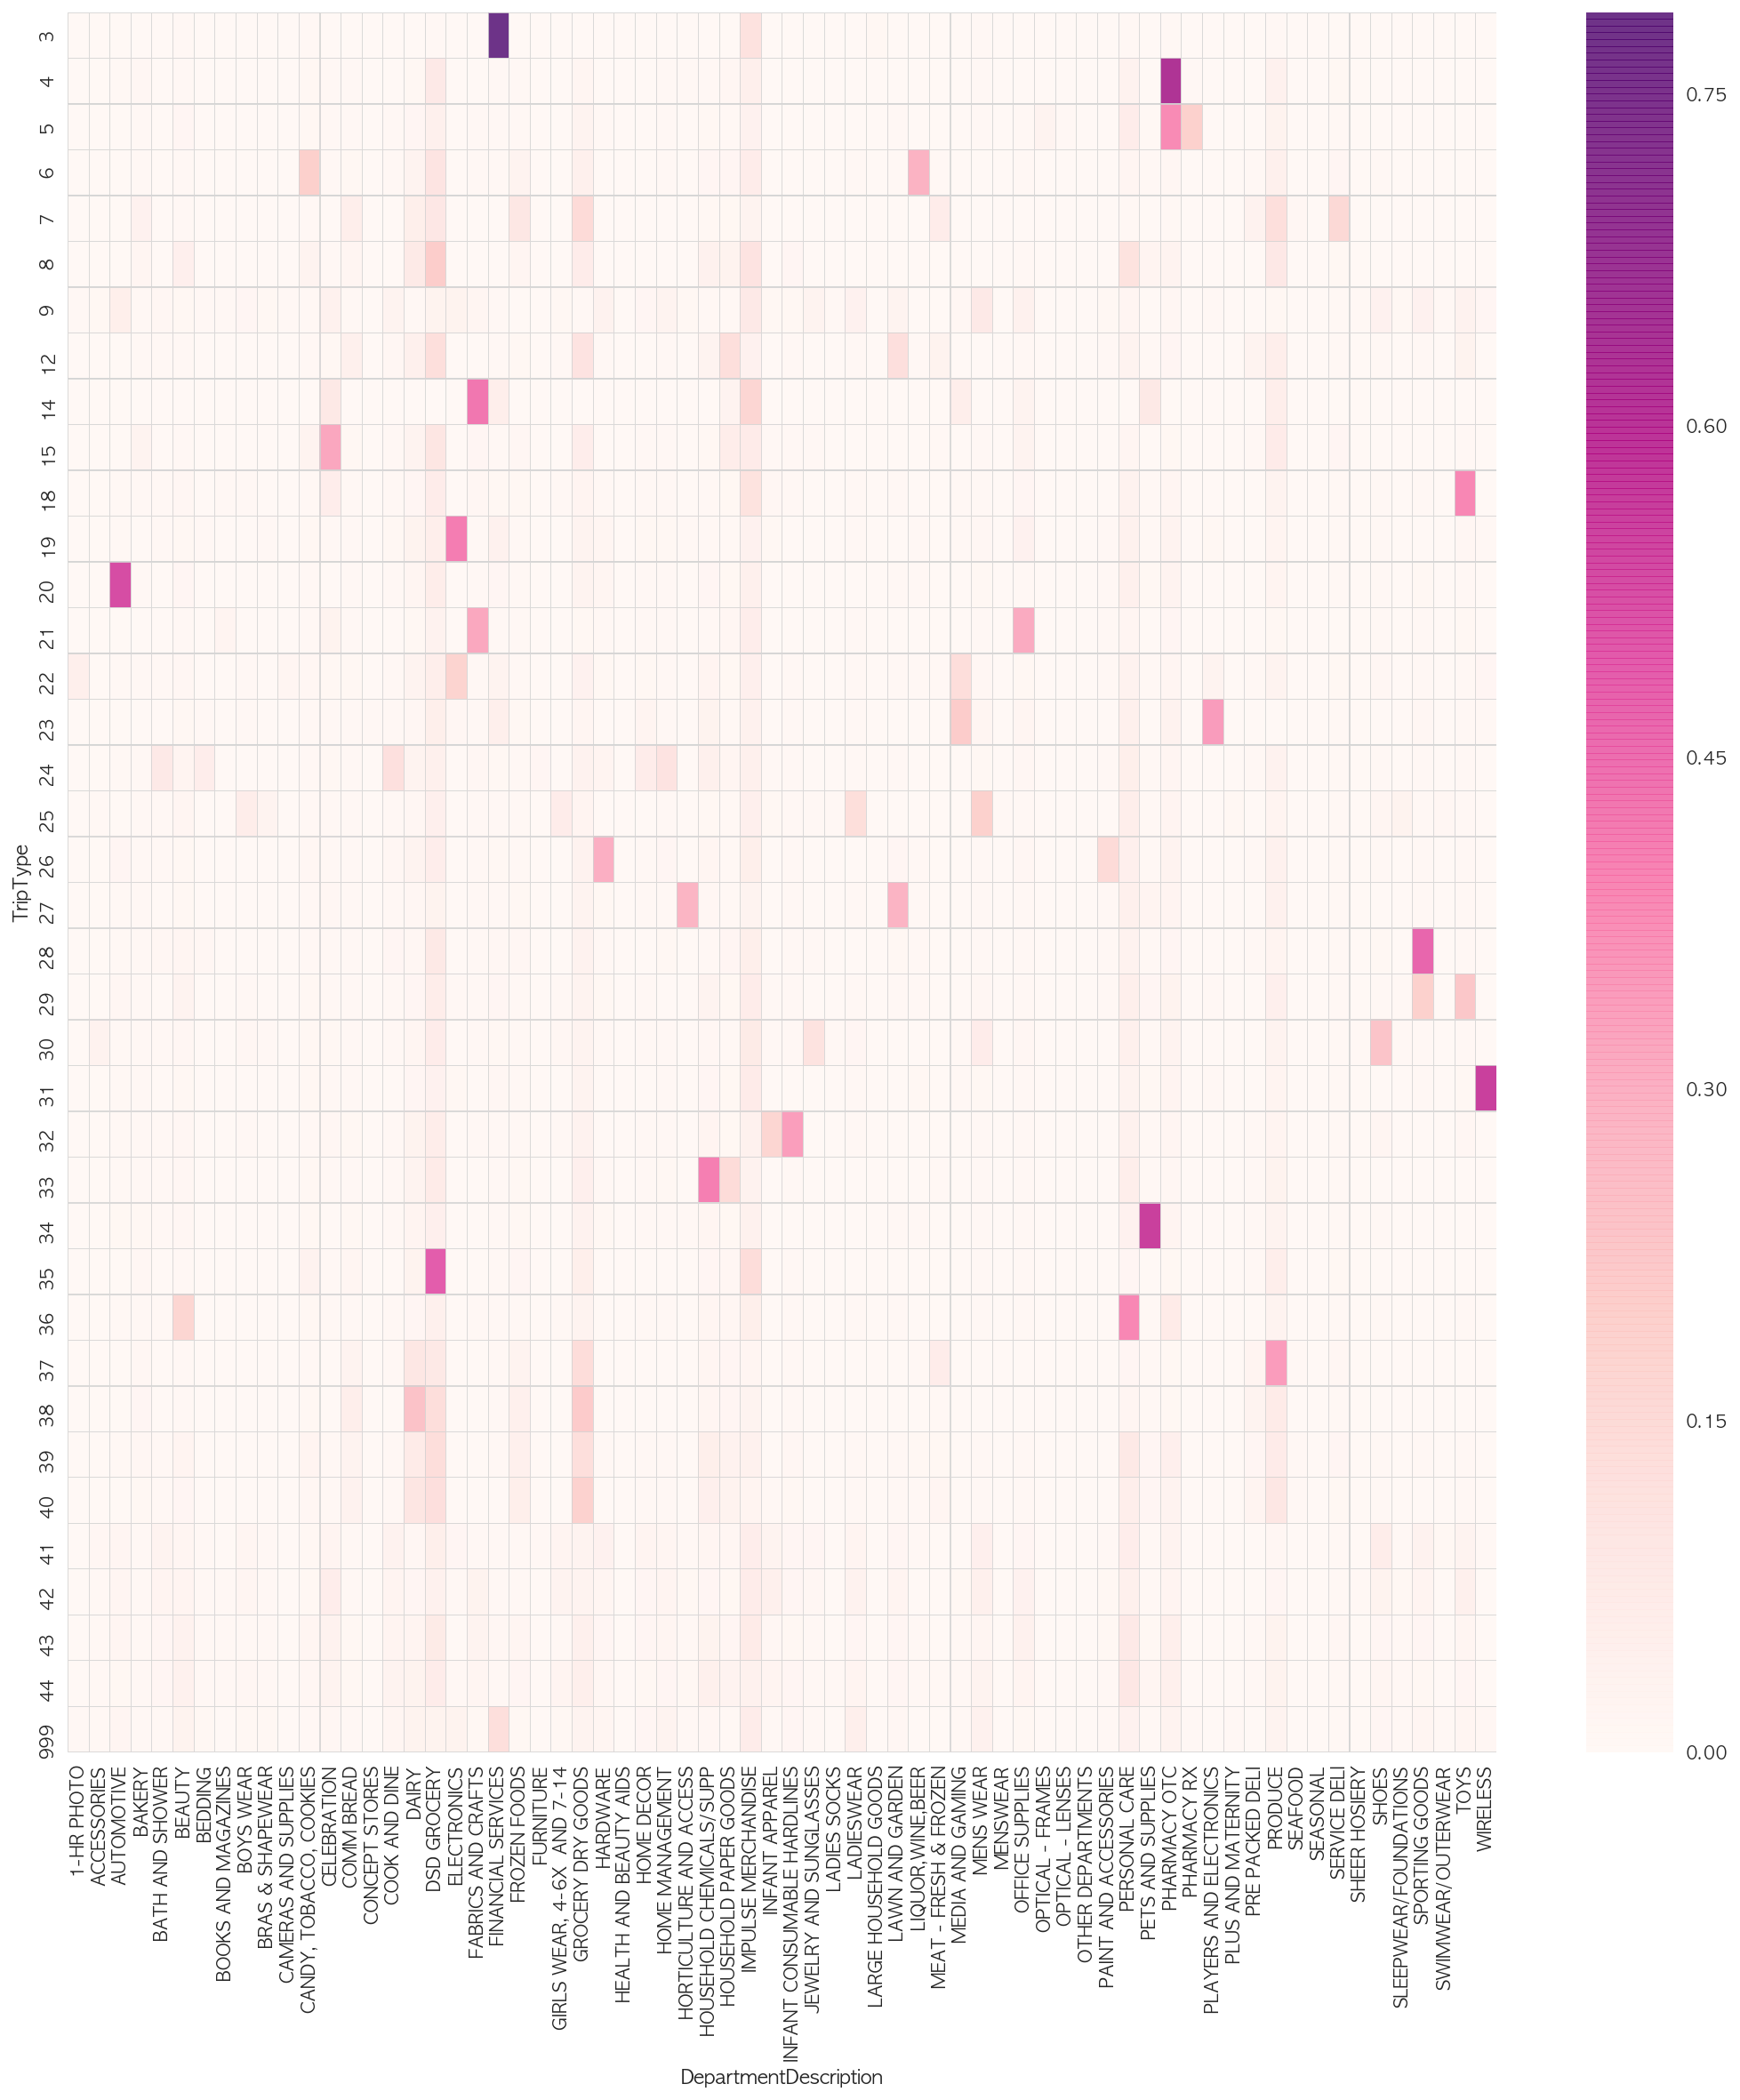

In [222]:
plt.figure(figsize=(18, 18))
sns.heatmap(f_dd.div(f_dd.iloc[:].sum()).T, linecolor="lightgrey", linewidths=0.02, cmap="RdPu", alpha=.8)
plt.show()

In [220]:
f_dd.div(f_dd.iloc[:].sum())

TripType,3,4,5,6,7,8,9,12,14,15,...,36,37,38,39,40,41,42,43,44,999
DepartmentDescription,,,,,,,,,,,,,,,,,,,,,
1-HR PHOTO,0.000293,0.000000,0.000072,0.000294,0.000129,0.000000,0.004779,0.000000,0.000000,0.002386,...,0.000319,0.000000,0.000068,0.000000,0.000006,0.000182,0.000360,0.000157,0.000000,0.004094
ACCESSORIES,0.000293,0.001111,0.001157,0.000882,0.000475,0.000263,0.011110,0.000000,0.000000,0.001684,...,0.001411,0.000463,0.000474,0.000996,0.000661,0.014569,0.007776,0.003615,0.003879,0.003287
AUTOMOTIVE,0.002932,0.003333,0.002894,0.001470,0.001338,0.002459,0.053103,0.001901,0.000000,0.000702,...,0.004007,0.001492,0.001897,0.004571,0.002357,0.019122,0.019362,0.020273,0.010263,0.020988
BAKERY,0.000733,0.014444,0.004775,0.006761,0.038714,0.020724,0.003644,0.007605,0.000000,0.030312,...,0.003779,0.013990,0.017543,0.014332,0.009731,0.006738,0.004635,0.007858,0.006236,0.008880
BATH AND SHOWER,0.001173,0.000000,0.001809,0.001764,0.000216,0.001581,0.013321,0.006654,0.000000,0.001684,...,0.005464,0.001414,0.000610,0.003586,0.003127,0.026771,0.022658,0.015873,0.017826,0.008707
BEAUTY,0.003518,0.007778,0.016784,0.006761,0.003237,0.048823,0.009796,0.008555,0.000000,0.008560,...,0.174976,0.005092,0.006062,0.023212,0.015502,0.021490,0.022864,0.036618,0.040955,0.031252
BEDDING,0.000586,0.000000,0.000506,0.000588,0.000345,0.000263,0.007765,0.000475,0.000000,0.000421,...,0.001093,0.000514,0.000373,0.001772,0.001144,0.009106,0.007312,0.003772,0.004076,0.011301
BOOKS AND MAGAZINES,0.000586,0.000000,0.001085,0.000588,0.000647,0.000746,0.006033,0.000475,0.000000,0.001544,...,0.000956,0.000566,0.000610,0.001111,0.000845,0.002185,0.006900,0.004715,0.003437,0.001499
BOYS WEAR,0.001319,0.000000,0.001085,0.000294,0.000259,0.000702,0.016307,0.001426,0.000000,0.002386,...,0.001639,0.000411,0.000711,0.001992,0.001615,0.020579,0.021010,0.006129,0.013848,0.010667


In [70]:
f_fl = pd.pivot_table(data=f_fl_, index="FinelineNumber", columns="TripType", values="Size", fill_value=0)

In [71]:
f_fl

TripType,3,4,5,6,7,8,9,12,14,15,...,36,37,38,39,40,41,42,43,44,999
FinelineNumber,,,,,,,,,,,,,,,,,,,,,
0.0,826,5,51,15,66,0,3,7,2,51,...,120,120,111,436,514,33,114,92,127,209
1.0,0,0,3,0,5,36,12,0,0,4,...,79,4,2,90,114,1,11,4,14,7
2.0,76,0,3,0,1,3,9,0,0,0,...,17,3,1,19,24,0,9,7,5,6
3.0,1,0,1,0,0,2,3,0,0,1,...,4,1,0,13,14,0,11,2,2,9
4.0,0,2,1,1,0,0,9,0,0,4,...,2,3,2,25,42,2,16,6,17,12
5.0,0,0,8,1,3,30,12,0,0,3,...,49,5,11,78,79,3,14,2,21,10
6.0,3,1,6,0,2,4,46,4,0,55,...,9,12,4,51,76,8,59,5,48,66
7.0,0,0,0,0,0,3,3,0,0,0,...,7,0,1,8,11,1,2,3,5,3
8.0,0,0,0,0,0,2,9,0,0,10,...,0,0,1,9,4,0,7,0,2,4


In [226]:
try_new_stuff_1 = try_new_stuff.groupby("FinelineNumber").size().reset_index(name="Count")

In [229]:
fl = try_new_stuff_1[try_new_stuff_1["Count"] == 1].FinelineNumber.values

In [244]:
ex = try_new_stuff[try_new_stuff.FinelineNumber.isin(fl)]

In [246]:
sc = ex.groupby("DepartmentDescription").agg({"ScanCount" : np.max}).ScanCount.values

In [253]:
sc

array([  18,   46,   29,   51,  113,  262,   81,  190,  126,  131,   21,
        464, 1464, 1418,  175, 1886, 3185,  103,  124,  432, 1541,   17,
         66, 2526,  111,  124,  111,  237, 1074,   70,  318,  151,  817,
        133,   47,  125,  124,  750,  368,  263,  227,   41,  450,   25,
        134,  952, 1587,  495,    9,  186,   17, 1295,  458,  532,    1,
        294,   26,  418,  117,  229,   64,   94,   76])

In [250]:
ex = ex[ex.ScanCount.isin(sc)]

In [277]:
ex[ex.DepartmentDescription == "WIRELESS"]

,FinelineNumber,DepartmentDescription,ScanCount
226,45.0,WIRELESS,1
1852,790.0,WIRELESS,26
2008,890.0,WIRELESS,1
2097,965.0,WIRELESS,76
2444,1140.0,WIRELESS,1
3225,1722.0,WIRELESS,1
3235,1733.0,WIRELESS,25
3282,1765.0,WIRELESS,1
3342,1876.0,WIRELESS,1
3343,1877.0,WIRELESS,1


In [279]:
fl_list = []
for dd in ex.DepartmentDescription.unique():
    tmp = ex[ex.DepartmentDescription == dd]
    sc_li = list(tmp.ScanCount.values)
    fl_li = tmp.FinelineNumber.values
    sc_max = tmp.ScanCount.max()
    idx = sc_li.index(sc_max)
    fl_list.append(fl_li[idx])

In [286]:
fl_list = np.array(fl_list).astype(str)

In [288]:
new_df = pd.concat([df_train_dd, df_train_fl[fl_list]], axis = 1)

In [358]:
def get_flat_type_user(df_, col = "DepartmentDescription"):
    """
        예:) vn_dd_more_than_one, vn_dd_one = get_flat_type_user(df_decoded) 반드시 df는 decoding 함수로 decoded된 것을 넣을 것.
    """
    df = df_.copy()
    df_count = df.groupby(["VisitNumber", col]).sum()["ScanCount"].reset_index(name="Sc_sum")
    df_count["Sc_sum"] = np.where(df_count["Sc_sum"] < 0, 0, df_count["Sc_sum"])
    df_count = df_count.dropna()
    df_count_total = df_count.groupby("VisitNumber").sum()["Sc_sum"].reset_index(name="Total")

    df_merged = pd.merge(df_count, df_count_total, on="VisitNumber")
    df_merged["P"] = df_merged["Sc_sum"].div(df_merged["Total"])
    
    num_category_li = []
    for i, vn in enumerate(df_merged.VisitNumber.unique()):
        tmp_df = df_merged[df_merged["VisitNumber"] == vn]
        if tmp_df.Total.values[0] == 0:
            num_category_li.append(0)
        else:
            num_of_category = len(tmp_df[col].unique())
            num_category_li.append(num_of_category)
        if i % 5000 == 0:
            print(str(i) + "까지 진행됨.")
    
    return num_category_li

In [294]:
sc_total = get_flat_type_user(df_decoded).Total.values

In [317]:
num_fl = get_flat_type_user(df_decoded, "FinelineNumber")

0까지 진행됨.
5000까지 진행됨.
10000까지 진행됨.
15000까지 진행됨.
20000까지 진행됨.
25000까지 진행됨.
30000까지 진행됨.
35000까지 진행됨.
40000까지 진행됨.
45000까지 진행됨.
50000까지 진행됨.
55000까지 진행됨.
60000까지 진행됨.
65000까지 진행됨.
70000까지 진행됨.
75000까지 진행됨.
80000까지 진행됨.
85000까지 진행됨.
90000까지 진행됨.
95000까지 진행됨.


In [310]:
num_dd = get_flat_type_user(df_decoded)

0까지 진행됨.
5000까지 진행됨.
10000까지 진행됨.
15000까지 진행됨.
20000까지 진행됨.
25000까지 진행됨.
30000까지 진행됨.
35000까지 진행됨.
40000까지 진행됨.
45000까지 진행됨.
50000까지 진행됨.
55000까지 진행됨.
60000까지 진행됨.
65000까지 진행됨.
70000까지 진행됨.
75000까지 진행됨.
80000까지 진행됨.
85000까지 진행됨.
90000까지 진행됨.
95000까지 진행됨.


In [314]:
new_df["N_DD"] = num_dd

In [318]:
new_df["N_FL"] = num_fl

In [321]:
num_company = get_flat_type_user(df_decoded, "Company")

0까지 진행됨.
5000까지 진행됨.
10000까지 진행됨.
15000까지 진행됨.
20000까지 진행됨.
25000까지 진행됨.
30000까지 진행됨.
35000까지 진행됨.
40000까지 진행됨.
45000까지 진행됨.
50000까지 진행됨.
55000까지 진행됨.
60000까지 진행됨.
65000까지 진행됨.
70000까지 진행됨.
75000까지 진행됨.
80000까지 진행됨.
85000까지 진행됨.
90000까지 진행됨.
95000까지 진행됨.


In [322]:
new_df["N_COMPANY"] = num_company

In [323]:
af.saveDataFrameToCsv(new_df, "new_df_dd_and_breif_fl_n_dd_n_fl_n_company")

In [359]:
num_upc = get_flat_type_user(df_decoded, "Upc")

0까지 진행됨.
5000까지 진행됨.
10000까지 진행됨.
15000까지 진행됨.
20000까지 진행됨.
25000까지 진행됨.
30000까지 진행됨.
35000까지 진행됨.
40000까지 진행됨.
45000까지 진행됨.
50000까지 진행됨.
55000까지 진행됨.
60000까지 진행됨.
65000까지 진행됨.
70000까지 진행됨.
75000까지 진행됨.
80000까지 진행됨.
85000까지 진행됨.
90000까지 진행됨.
95000까지 진행됨.


In [ ]:
len(num_upc)

In [363]:
len(upc_vn_li)

95301

In [ ]:
not_in_li

In [353]:
not_in_li = []
dd_vn_li = df_train_dd.VisitNumber.unique()
upc_vn_li = num_upc.VisitNumber.unique()
for idx, vn in enumerate(dd_vn_li):
    if vn not in upc_vn_li:
        not_in_li.append(vn)
    if idx % 5000 == 0:
        print(idx)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000


In [380]:
new_df.set_index("VisitNumber", inplace=True)

In [381]:
new_df.at[upc_vn_li,"N_UPC"] = num_upc

In [386]:
new_df = new_df.reset_index()

In [355]:
getSpecifiedVisitNumberData(df_train, 829)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
1901,999,829,Friday,4.719849e+11,-1,"GIRLS WEAR, 4-6X AND 7-14",2710.0
1902,999,829,Friday,4.719849e+11,-1,"GIRLS WEAR, 4-6X AND 7-14",2710.0


In [354]:
not_in_li

[829,
 928,
 1049,
 1516,
 1739,
 2754,
 2840,
 3533,
 4571,
 4769,
 6283,
 7703,
 7776,
 8772,
 9160,
 9375,
 9727,
 10158,
 10515,
 10842,
 11314,
 11474,
 11612,
 11862,
 13381,
 14136,
 14470,
 14781,
 14783,
 15083,
 17124,
 18127,
 18201,
 18773,
 21742,
 22470,
 23442,
 23999,
 24468,
 24474,
 25935,
 26033,
 26238,
 26702,
 27783,
 27789,
 27791,
 28299,
 28469,
 28794,
 29160,
 30007,
 31473,
 31766,
 33352,
 33370,
 34642,
 34674,
 34796,
 34996,
 35788,
 36730,
 37538,
 37933,
 38667,
 40803,
 40995,
 41493,
 43487,
 43492,
 43806,
 45159,
 45543,
 45832,
 46120,
 46130,
 46271,
 47047,
 47094,
 47301,
 47450,
 47758,
 48201,
 48318,
 48806,
 49965,
 50363,
 50610,
 50623,
 52351,
 52354,
 52747,
 52903,
 53025,
 53140,
 53859,
 54352,
 54429,
 54482,
 54505,
 54517,
 55049,
 55385,
 55592,
 55630,
 57307,
 57512,
 58522,
 58578,
 59023,
 60404,
 61428,
 62610,
 62724,
 62786,
 63493,
 63596,
 63789,
 64067,
 64340,
 64669,
 65698,
 66291,
 66488,
 67493,
 70671,
 70822,
 71

In [326]:
len(num_upc)

95301

In [361]:
new_df["N_UPC"] = 0

In [387]:
af.saveDataFrameToCsv(new_df, "new_df_dd_and_breif_fl_n_dd_n_fl_n_company_n_upc")

In [295]:
new_df["Scancount_total"] = sc_total

In [320]:
af.saveDataFrameToCsv(new_df, "new_df_dd_and_breif_fl_n_dd_n_fl")

In [66]:
digging_fl = pd.pivot_table(data=try_new_stuff, index="FinelineNumber", columns="DepartmentDescription", values="ScanCount", fill_value=0)

In [67]:
digging_fl

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
FinelineNumber,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0,0,0,14,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,16,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,2
5.0,0,0,12,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,3
6.0,0,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7.0,0,0,0,0,0,41,0,2,0,0,...,0,0,0,0,0,0,0,0,0,3
8.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [3]:
# df_decoded = du.decodeStuffNeedsToBeDecoded(df_train)

In [403]:
train_fl_cols = df_train.FinelineNumber.unique()

In [404]:
test_fl_cols = df_test.FinelineNumber.unique()

In [401]:
len(train_fl_cols), len(test_fl_cols)

(5196, 5204)

In [406]:
intersected_li = np.intersect1d(train_fl_cols, test_fl_cols)

In [407]:
len(intersected_li)

5045

In [411]:
intersected_li = intersected_li.astype(str)

In [451]:
cols = ['VisitNumber', 'Return', 'TripType', '-1', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday']
test_cols = ['VisitNumber', 'Return', '-1', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday']

In [418]:
new_fl_df = pd.concat([df_train_fl[cols], df_train_fl[intersected_li]], axis = 1)

In [420]:
cols_do_not_need = ['VisitNumber', 'Return', 'TripType', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday']

In [426]:
cols_dd = [col for col in df_train_dd.columns if col not in cols_do_not_need]

In [425]:
df_train_dd["MENS WEAR"] = df_train_dd["MENS WEAR"] + df_train_dd["MENSWEAR"]
df_train_dd.drop("MENSWEAR", axis = 1, inplace = True)

In [453]:
new_fl_test_df = pd.concat([df_test_fl[test_cols], df_test_fl[intersected_li]], axis = 1)

In [ ]:
new_fl_df = pd.concat([df_train_fl[cols], df_train_fl[intersected_li]], axis = 1)

In [427]:
len(cols_dd)

68

In [429]:
new_fl_df = pd.concat([df_train_dd[cols_dd], new_fl_df], axis = 1)

In [460]:
new_fl_test_df = pd.concat([df_test_dd[cols_dd],new_fl_test_df], axis = 1)

In [430]:
new_fl_df.head()

,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,9961.0,9966.0,9967.0,9970.0,9971.0,9974.0,9975.0,9991.0,9997.0,9998.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [431]:
train_X , train_y = af.get_df_to_fit(new_fl_df)

In [435]:
from scipy.sparse import csr_matrix

In [432]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder().fit(train_y)
y_labeled = label_enc.transform(train_y)

In [433]:
train_X, test_X, train_y, test_y = train_test_split(train_X, y_labeled, random_state=0)

In [436]:
csr_train = csr_matrix(train_X.values)
csr_test = csr_matrix(test_X.values)

In [ ]:
new_fl_test_df

In [468]:
csr_test_fl = csr_matrix(X_test.values)

In [465]:
X_test = af.get_df_to_fit(new_fl_test_df, True)

In [467]:
X_test.drop("index", axis = 1, inplace=True)

In [469]:
dtest_fl = xgb.DMatrix(csr_test_fl, feature_names = X_test.columns)

In [437]:
if xgboost:
    dtrain = xgb.DMatrix(csr_train, label=train_y, feature_names = train_X.columns)
    dtest = xgb.DMatrix(csr_test, label=test_y, feature_names = train_X.columns)
    num_boost_round = 300
    params = {'objective': 'multi:softprob', 
              'eval_metric': 'mlogloss',
              'num_class':38, 
              'max_delta_step': 3, 
              'eta': 0.2}

    evals = [(dtrain, 'train'), (dtest, 'eval')]

    bst = xgb.train(params=params,  
                    dtrain=dtrain, 
                    num_boost_round=num_boost_round, 
                    evals=evals,
                    early_stopping_rounds=10,)

[0]	train-mlogloss:3.1138	eval-mlogloss:3.1257
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:2.67886	eval-mlogloss:2.70454
[2]	train-mlogloss:2.34107	eval-mlogloss:2.3785
[3]	train-mlogloss:2.08623	eval-mlogloss:2.13384
[4]	train-mlogloss:1.90948	eval-mlogloss:1.96668
[5]	train-mlogloss:1.77373	eval-mlogloss:1.83927
[6]	train-mlogloss:1.66388	eval-mlogloss:1.73716
[7]	train-mlogloss:1.57165	eval-mlogloss:1.65191
[8]	train-mlogloss:1.49479	eval-mlogloss:1.58062
[9]	train-mlogloss:1.42756	eval-mlogloss:1.52006
[10]	train-mlogloss:1.36915	eval-mlogloss:1.46723
[11]	train-mlogloss:1.31859	eval-mlogloss:1.42105
[12]	train-mlogloss:1.27345	eval-mlogloss:1.38153
[13]	train-mlogloss:1.23303	eval-mlogloss:1.34574
[14]	train-mlogloss:1.19737	eval-mlogloss:1.3152
[15]	train-mlogloss:1.16505	eval-mlogloss:1.28638
[16]	train-mlogloss:1.13538	eval-mlogloss:1.26062
[17]	train-ml

[156]	train-mlogloss:0.503632	eval-mlogloss:0.839738
[157]	train-mlogloss:0.502521	eval-mlogloss:0.839298
[158]	train-mlogloss:0.500959	eval-mlogloss:0.838467
[159]	train-mlogloss:0.499131	eval-mlogloss:0.837593
[160]	train-mlogloss:0.497796	eval-mlogloss:0.837095
[161]	train-mlogloss:0.496547	eval-mlogloss:0.83659
[162]	train-mlogloss:0.495354	eval-mlogloss:0.836008
[163]	train-mlogloss:0.49406	eval-mlogloss:0.835434
[164]	train-mlogloss:0.492816	eval-mlogloss:0.83484
[165]	train-mlogloss:0.491475	eval-mlogloss:0.834175
[166]	train-mlogloss:0.490352	eval-mlogloss:0.833733
[167]	train-mlogloss:0.489215	eval-mlogloss:0.833407
[168]	train-mlogloss:0.487978	eval-mlogloss:0.83296
[169]	train-mlogloss:0.48691	eval-mlogloss:0.832558
[170]	train-mlogloss:0.48576	eval-mlogloss:0.832229
[171]	train-mlogloss:0.484575	eval-mlogloss:0.831724
[172]	train-mlogloss:0.483504	eval-mlogloss:0.831368
[173]	train-mlogloss:0.482137	eval-mlogloss:0.830803
[174]	train-mlogloss:0.480846	eval-mlogloss:0.830156

In [441]:
num_boost_round = 1000

In [442]:
 params = {'objective': 'multi:softprob', 
              'eval_metric': 'mlogloss',
              'num_class':38, 
#               'max_delta_step': 3, 
              'eta': 0.2}

In [443]:
bst = xgb.train(params=params,  
                    dtrain=dtrain, 
                    num_boost_round=num_boost_round, 
                    evals=evals,
                    early_stopping_rounds=10,)

[0]	train-mlogloss:2.46238	eval-mlogloss:2.48716
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:2.18065	eval-mlogloss:2.21908
[2]	train-mlogloss:1.98483	eval-mlogloss:2.03384
[3]	train-mlogloss:1.83685	eval-mlogloss:1.89434
[4]	train-mlogloss:1.71812	eval-mlogloss:1.78341
[5]	train-mlogloss:1.62044	eval-mlogloss:1.69293
[6]	train-mlogloss:1.53751	eval-mlogloss:1.61664
[7]	train-mlogloss:1.46708	eval-mlogloss:1.55265
[8]	train-mlogloss:1.4052	eval-mlogloss:1.49656
[9]	train-mlogloss:1.35211	eval-mlogloss:1.44846
[10]	train-mlogloss:1.30493	eval-mlogloss:1.40641
[11]	train-mlogloss:1.26263	eval-mlogloss:1.36921
[12]	train-mlogloss:1.22532	eval-mlogloss:1.33705
[13]	train-mlogloss:1.19081	eval-mlogloss:1.30695
[14]	train-mlogloss:1.16008	eval-mlogloss:1.28123
[15]	train-mlogloss:1.13214	eval-mlogloss:1.2574
[16]	train-mlogloss:1.10641	eval-mlogloss:1.23558
[17]	train-

[156]	train-mlogloss:0.5077	eval-mlogloss:0.848753
[157]	train-mlogloss:0.506425	eval-mlogloss:0.848058
[158]	train-mlogloss:0.505152	eval-mlogloss:0.847502
[159]	train-mlogloss:0.503759	eval-mlogloss:0.846905
[160]	train-mlogloss:0.502335	eval-mlogloss:0.846319
[161]	train-mlogloss:0.500829	eval-mlogloss:0.845556
[162]	train-mlogloss:0.499545	eval-mlogloss:0.845179
[163]	train-mlogloss:0.498197	eval-mlogloss:0.844563
[164]	train-mlogloss:0.49689	eval-mlogloss:0.844082
[165]	train-mlogloss:0.495435	eval-mlogloss:0.843484
[166]	train-mlogloss:0.494262	eval-mlogloss:0.843121
[167]	train-mlogloss:0.493124	eval-mlogloss:0.842748
[168]	train-mlogloss:0.491929	eval-mlogloss:0.842192
[169]	train-mlogloss:0.490824	eval-mlogloss:0.841878
[170]	train-mlogloss:0.489713	eval-mlogloss:0.841516
[171]	train-mlogloss:0.488502	eval-mlogloss:0.840998
[172]	train-mlogloss:0.487388	eval-mlogloss:0.840666
[173]	train-mlogloss:0.486207	eval-mlogloss:0.840218
[174]	train-mlogloss:0.485027	eval-mlogloss:0.839

[312]	train-mlogloss:0.366881	eval-mlogloss:0.802913
[313]	train-mlogloss:0.366164	eval-mlogloss:0.80272
[314]	train-mlogloss:0.365477	eval-mlogloss:0.802522
[315]	train-mlogloss:0.364769	eval-mlogloss:0.80234
[316]	train-mlogloss:0.364181	eval-mlogloss:0.802178
[317]	train-mlogloss:0.363585	eval-mlogloss:0.802047
[318]	train-mlogloss:0.362921	eval-mlogloss:0.801924
[319]	train-mlogloss:0.362347	eval-mlogloss:0.801798
[320]	train-mlogloss:0.361796	eval-mlogloss:0.801719
[321]	train-mlogloss:0.361221	eval-mlogloss:0.801638
[322]	train-mlogloss:0.360509	eval-mlogloss:0.801534
[323]	train-mlogloss:0.359772	eval-mlogloss:0.80141
[324]	train-mlogloss:0.359218	eval-mlogloss:0.801387
[325]	train-mlogloss:0.358649	eval-mlogloss:0.801319
[326]	train-mlogloss:0.358017	eval-mlogloss:0.801158
[327]	train-mlogloss:0.357438	eval-mlogloss:0.800997
[328]	train-mlogloss:0.356873	eval-mlogloss:0.800844
[329]	train-mlogloss:0.356193	eval-mlogloss:0.800747
[330]	train-mlogloss:0.355665	eval-mlogloss:0.800

[468]	train-mlogloss:0.288033	eval-mlogloss:0.792379
[469]	train-mlogloss:0.287669	eval-mlogloss:0.79248
[470]	train-mlogloss:0.287255	eval-mlogloss:0.792541
[471]	train-mlogloss:0.286891	eval-mlogloss:0.792574
[472]	train-mlogloss:0.286485	eval-mlogloss:0.792602
[473]	train-mlogloss:0.286089	eval-mlogloss:0.792541
[474]	train-mlogloss:0.285726	eval-mlogloss:0.792508
[475]	train-mlogloss:0.285377	eval-mlogloss:0.792582
[476]	train-mlogloss:0.284994	eval-mlogloss:0.792605
[477]	train-mlogloss:0.284641	eval-mlogloss:0.792515
[478]	train-mlogloss:0.284268	eval-mlogloss:0.792471
Stopping. Best iteration:
[468]	train-mlogloss:0.288033	eval-mlogloss:0.792379



In [ ]:
l

In [450]:
bst.predict(dtrain)

array([[6.1516538e-08, 7.8237994e-09, 4.7941097e-07, ..., 1.9745365e-05,
        3.0934877e-06, 5.4863666e-04],
       [7.5475878e-01, 3.3340933e-07, 4.5371526e-05, ..., 2.4361517e-04,
        1.9073808e-05, 2.4144946e-01],
       [2.0865602e-05, 2.2822618e-07, 9.1180496e-05, ..., 3.7704455e-04,
        2.2888424e-05, 3.8959056e-02],
       ...,
       [3.7450855e-06, 3.5674580e-07, 7.9091835e-05, ..., 9.8725408e-04,
        5.0731958e-04, 2.0700897e-04],
       [4.5191926e-09, 1.6990510e-08, 6.5175473e-06, ..., 1.3291796e-04,
        8.1698946e-04, 8.6807822e-06],
       [1.1618909e-05, 6.0778111e-06, 2.3029534e-04, ..., 6.6929293e-04,
        5.3264768e-05, 1.5684430e-02]], dtype=float32)

In [474]:
%time dtest_fl

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


In [475]:
%time y_pred_proba = bst.predict(dtest_fl)

CPU times: user 11min 51s, sys: 2.13 s, total: 11min 53s
Wall time: 11min 55s


In [476]:
len(y_pred_proba)

95674

In [477]:
submit_xgb_train = af.make_submission_df(submission, y_pred_proba)

In [478]:
af.saveDataFrameToCsv(submit_xgb_train, "submit_xgb_train")